# Chapter 3: A Simple Classification Problem

# Imports

In [28]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
from mlprocess import MLProcess
import matplotlib.pyplot as plt

# Data Generation

x: (100, 2) y: (100,)
X_train: (80, 2) X_val: (20, 2) y_train: (80,) y_val: (20,)


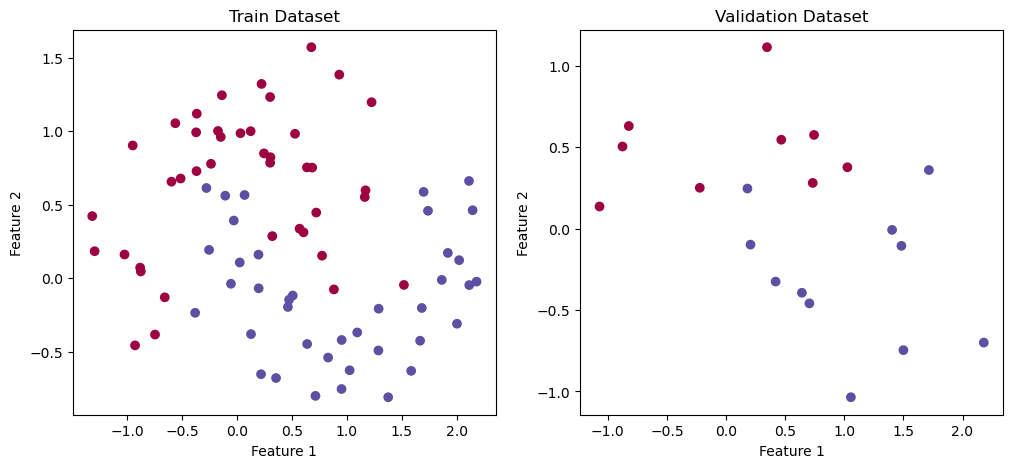

In [29]:
X, y = make_moons(n_samples=100, noise=0.3, random_state=0)

print('x:', X.shape, 'y:', y.shape)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=13)

print('X_train:', X_train.shape, 'X_val:', X_val.shape, 'y_train:', y_train.shape, 'y_val:', y_val.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot train dataset
ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral)
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_title('Train Dataset')

# Plot validation dataset
ax2.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=plt.cm.Spectral)
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.set_title('Validation Dataset')

plt.show()

# Feature Standarization

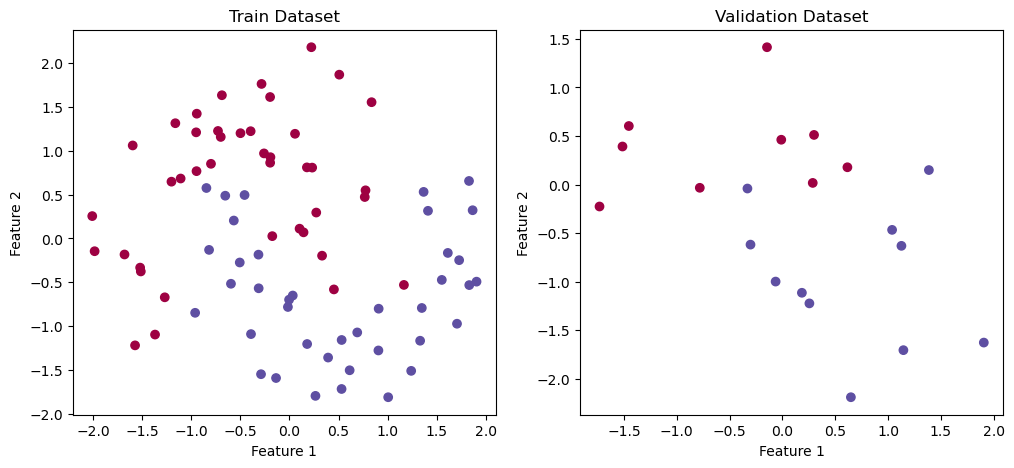

In [30]:
sc = StandardScaler()
# only fit the features on the training dataset to prevent leaking from test to train datasets
sc.fit(X_train)

X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot train dataset
ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral)
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
ax1.set_title("Train Dataset")

# Plot validation dataset
ax2.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=plt.cm.Spectral)
ax2.set_xlabel("Feature 1")
ax2.set_ylabel("Feature 2")
ax2.set_title("Validation Dataset")

plt.show()

# Data Preparation

In [31]:
torch.manual_seed(13)

x_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.tensor(X_val).float()
y_val_tensor = torch.tensor(y_val.reshape(-1, 1)).float()

# Builds pytorch datasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=10)

# Probability Function

Text(0.5, 1.0, 'Log Odds Ratio vs Probability')

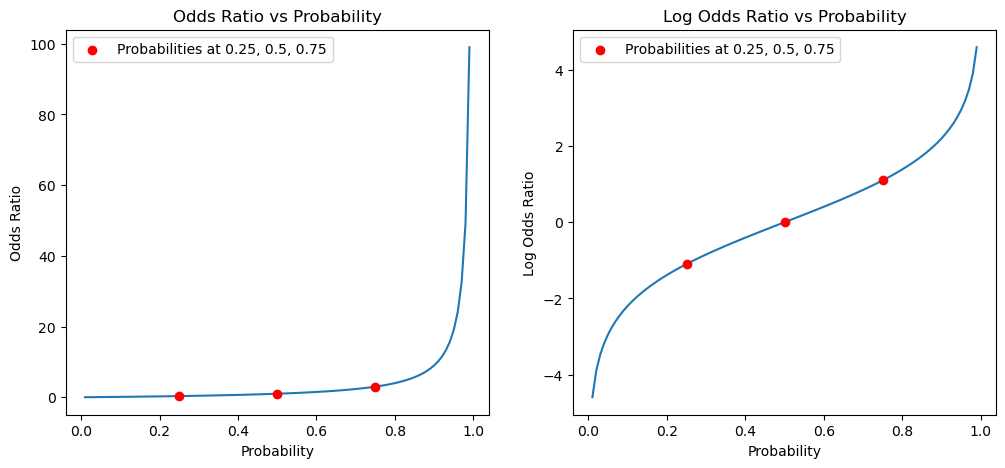

In [32]:
def odds_ratio(prob):
    return prob / (1 - prob)


def log_odds_ratio(prob):
    return np.log(odds_ratio(prob))


p = 0.75
q = 1 - p
p, odds_ratio(p), log_odds_ratio(p), q, odds_ratio(q), log_odds_ratio(q)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot odds_ratio in the range 0 to 1
probs = np.linspace(0.01, 0.99, 100)
ax1.plot(probs, odds_ratio(probs))
ax1.scatter(
    [0.25, 0.5, 0.75],
    odds_ratio(np.array([0.25, 0.5, 0.75])),
    color="red",
    label="Probabilities at 0.25, 0.5, 0.75",
    zorder=2,
)
ax1.legend()
ax1.set_xlabel("Probability")
ax1.set_ylabel("Odds Ratio")
ax1.set_title("Odds Ratio vs Probability")

# Plot log_odds_ratio in the range 0 to 1
ax2.plot(probs, log_odds_ratio(probs), zorder=1)
ax2.scatter(
    [0.25, 0.5, 0.75],
    log_odds_ratio(np.array([0.25, 0.5, 0.75])),
    color="red",
    label="Probabilities at 0.25, 0.5, 0.75",
    zorder=2,
)
ax2.legend()
ax2.set_xlabel("Probability")
ax2.set_ylabel("Log Odds Ratio")
ax2.set_title("Log Odds Ratio vs Probability")

# Sigmoid Function

Text(0.5, 1.0, 'Sigmoid vs Log Odds Ratio of Probabilities')

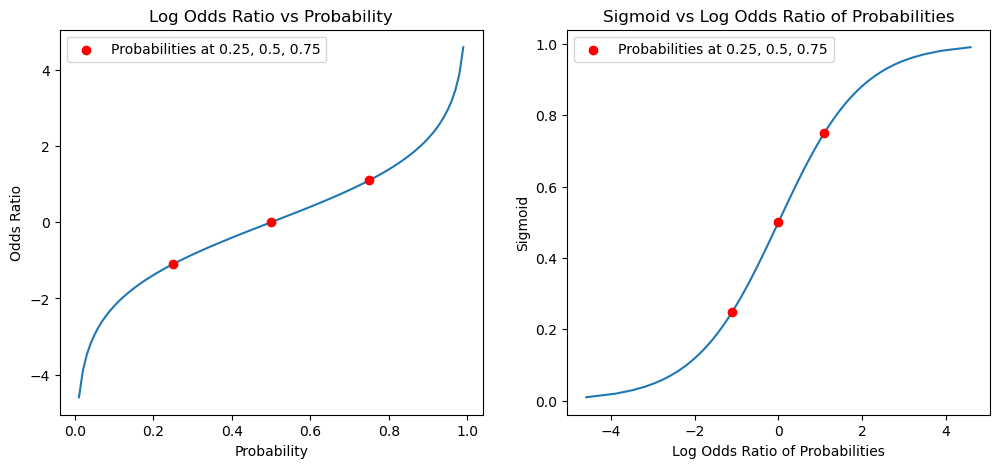

In [33]:
probs = np.linspace(0.01, 0.99, 100)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot odds_ratio in the range 0 to 1
ax1.plot(probs, log_odds_ratio(probs))
ax1.scatter(
    [0.25, 0.5, 0.75],
    log_odds_ratio(np.array([0.25, 0.5, 0.75])),
    color="red",
    label="Probabilities at 0.25, 0.5, 0.75",
    zorder=2,
)
ax1.legend()
ax1.set_xlabel("Probability")
ax1.set_ylabel("Odds Ratio")
ax1.set_title("Log Odds Ratio vs Probability")

# Plot log_odds_ratio in the range 0 to 1
ax2.plot(log_odds_ratio(probs), sigmoid(log_odds_ratio(probs)), zorder=1)
ax2.scatter(
    log_odds_ratio(np.array([0.25, 0.5, 0.75])),
    sigmoid(log_odds_ratio(np.array([0.25, 0.5, 0.75]))),
    color="red",
    label="Probabilities at 0.25, 0.5, 0.75",
    zorder=2,
)
ax2.legend()
ax2.set_xlabel("Log Odds Ratio of Probabilities")
ax2.set_ylabel("Sigmoid")
ax2.set_title("Sigmoid vs Log Odds Ratio of Probabilities")

# Binary Cross-Entropy Error: BCE
To calculate the BCE, we need to do the following:

- First, calculate the loss of the first class (y == 1)
$$
\sum_{i=1}^{N_{\text{pos}}} \log(\text{P}(y_i = 1))
$$

- Second, we calculate the loss of the second class (y == 0)
$$
\sum_{i=1}^{N_{\text{neg}}} \log(1 - \text{P}(y_i = 1))
$$

- Finally, we average both loss values and invert its sign:
$$
\text{BCE}(y) = -\frac{1}{(N_{\text{pos}} + N_{\text{neg}})} \left[ \sum_{i=1}^{N_{\text{pos}}} \log(\text{P}(y_i = 1)) + \sum_{i=1}^{N_{\text{neg}}} \log(1 - \text{P}(y_i = 1)) \right]
$$


In [34]:
dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([0.9, 0.2])

# Positive class (labels = 1)
positive_pred = dummy_predictions[dummy_labels == 1]
first_summation = torch.log(positive_pred).sum()

# Negative class (labels = 0)
negative_pred = dummy_predictions[dummy_labels == 0]
second_summation = torch.log(1 - negative_pred).sum()

# n = dummy_labels.size(0)
n_total = dummy_labels.size(0)

# BCE formula
loss = -(first_summation + second_summation) / n_total
loss

tensor(0.1643)

More involved equivalent formula:
$$
\text{BCE}(y) = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(\text{P}(y_i = 1)) + (1 - y_i) \log(1 - \text{P}(y_i = 1)) \right]
$$

In [35]:
summation = torch.sum(
    dummy_labels * torch.log(dummy_predictions) + (1- dummy_labels) * torch.log(1 - dummy_predictions)
)
loss - summation / n_total
loss

tensor(0.1643)

In [36]:
loss_fn = nn.BCELoss()

dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([0.9, 0.2])

loss = loss_fn(dummy_predictions, dummy_labels)
loss

tensor(0.1643)

# BCEWithLogitsLoss

In [37]:
loss_fn_logits = nn.BCEWithLogitsLoss(reduction="mean")

logit1 = log_odds_ratio(.9)
logit2 = log_odds_ratio(.2)

dummy_labels = torch.tensor([1.0, 0.0])
dummy_logits = torch.tensor([logit1, logit2])
display(dummy_logits)

loss = loss_fn_logits(dummy_logits, dummy_labels)
loss

tensor([ 2.1972, -1.3863], dtype=torch.float64)

tensor(0.1643)

# Imbalanced Dataset

In [38]:
# Imbalanced dataset, 3 times more negative samples
dummy_imb_labels = torch.tensor([1.0, 0.0, 0.0, 0.0])
dummy_imb_logits = torch.tensor([logit1, logit2, logit2, logit2])

n_neg = (dummy_imb_labels == 0).sum().float()
n_pos = (dummy_imb_labels == 1).sum().float()
pos_weight = (n_neg / n_pos).view(1)
display(pos_weight)

loss_fn_imb = nn.BCEWithLogitsLoss(reduction="sum", pos_weight=pos_weight)
loss = loss_fn_imb(dummy_imb_logits, dummy_imb_labels)
loss = loss / (pos_weight * n_pos + n_neg)
loss

tensor([3.])

tensor([0.1643])

# Logistic Regression Model

In [39]:
lr = 0.1
torch.manual_seed(42)

model = nn.Sequential()
model.add_module("linear", nn.Linear(2, 1))

# SDG optimizer
optimizer = optim.SGD(model.parameters(), lr=lr)

# BCE loss
loss_fn = nn.BCEWithLogitsLoss()

## Training

Device: mps


OrderedDict([('linear.weight', tensor([[ 1.1968, -1.9209]], device='mps:0')),
             ('linear.bias', tensor([-0.0620], device='mps:0'))])

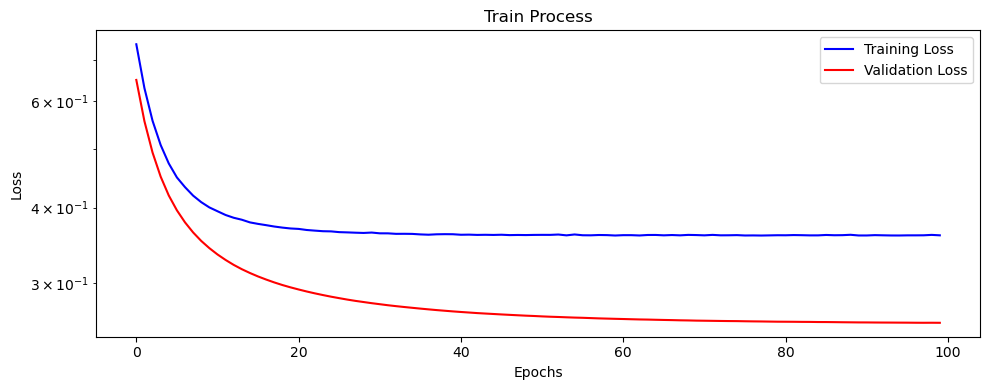

In [40]:
n_epochs = 100

mlp = MLProcess(model, loss_fn, optimizer)
mlp.set_loaders(train_loader, val_loader)
mlp.train(n_epochs)

display(model.state_dict())

fig = mlp.plot_losses()

# Inference

In [67]:
predictions = sigmoid(mlp.predict(x_val_tensor))
classes = (predictions > 0.5).astype(int)
validation_errors = np.abs((y_val.reshape(-1, 1) - classes))
validation_errors

array([[1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])